In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

%load_ext autoreload
%autoreload 2
from utils import show_heat_map, print_mutual_info, aggregate_data, resample_df, load_big_df
from utils import two_sig_signal, two_sig_signal_multi, get_yulu_df

In [9]:
df_raw = pd.read_csv("../simulation_data/output_2025-03-27_20250314_LINKUSDTOB500_ETHUSDTtrades_OI.csv")
df_buy, df_sell, df_ob = aggregate_data(df_raw)
df = resample_df(df_buy, df_sell, df_ob, '1T')
df

,mid,buy_size,buy_price_min,buy_price_max,sell_size,sell_price_min,sell_price_max
time,,,,,,,
2025-03-14 00:00:00,13.0045,373.46,1862.01,1864.42,346.55,1861.94,1864.41
2025-03-14 00:01:00,13.0045,169.45,1860.81,1863.49,455.25,1860.66,1863.49
2025-03-14 00:02:00,13.0395,201.14,1860.52,1863.40,139.74,1860.50,1863.39
2025-03-14 00:03:00,13.0545,90.80,1862.58,1864.68,158.45,1862.58,1864.67
2025-03-14 00:04:00,13.0155,126.74,1862.15,1864.57,150.98,1862.14,1864.54
...,...,...,...,...,...,...,...
2025-03-14 23:56:00,13.6495,200.14,1907.20,1909.19,447.22,1907.20,1909.18
2025-03-14 23:57:00,13.6505,97.38,1907.13,1908.90,200.30,1907.12,1908.89
2025-03-14 23:58:00,13.6415,152.68,1907.21,1908.92,246.69,1907.20,1908.90


In [25]:
def aggregate_data_r(df_raw):
    df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')

    df_buy = df_raw[df_raw['trade_side'] == 'Buy'].groupby('time', as_index=False).agg(
        trade_size_sum=('trade_size', 'sum'),
        trade_price_min=('trade_price', 'min'),
        trade_price_max=('trade_price', 'max')
    )

    df_sell = df_raw[df_raw['trade_side'] == 'Sell'].groupby('time', as_index=False).agg(
        trade_size_sum=('trade_size', 'sum'),
        trade_price_min=('trade_price', 'min'),
        trade_price_max=('trade_price', 'max')
    )

    df_buy.set_index('time', inplace=True)
    df_sell.set_index('time', inplace=True)

    dff = df_raw[df_raw['trade_side'] == 'Buy']
    dff['pv'] = dff['trade_size'] * dff['trade_price']
    result = dff.groupby('time').agg({
        'pv': 'sum',
        'trade_size': 'sum'
    })

    df_buy['vwap'] = result['pv'] / result['trade_size']

    dff = df_raw[df_raw['trade_side'] == 'Sell']
    dff['pv'] = dff['trade_size'] * dff['trade_price']
    result = dff.groupby('time').agg({
        'pv': 'sum',
        'trade_size': 'sum'
    })

    df_sell['vwap'] = result['pv'] / result['trade_size']

    df_ob = df_raw[df_raw['trade_side'].isna()].drop(columns=['trade_side', 'trade_size', 'trade_price'])
    df_ob.set_index('time', inplace=True)

    return df_buy, df_sell, df_ob

def resample_df(df_buy, df_sell, df_ob, time_step):
    df_buy_resampled = df_buy.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_price_min': 'min',  # Min for min price
            'trade_price_max': 'max',  # Max for max price
            'vwap': 'mean'
        }).rename(columns={'trade_size_sum': 'buy_size', 'trade_price_min': 'buy_price_min',  'trade_price_max': 'buy_price_max', 'vwap': 'buy_vwap'})
    df_sell_resampled = df_sell.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_price_min': 'min',  # Min for min price
            'trade_price_max': 'max',   # Max for max price
            'vwap': 'mean'
        }).rename(columns={'trade_size_sum': 'sell_size', 'trade_price_min': 'sell_price_min',  'trade_price_max': 'sell_price_max', 'vwap': 'sell_vwap'})
    df_ob_resampled = df_ob.resample(time_step).last()
    df = df_ob_resampled.join(df_buy_resampled.join(df_sell_resampled, how='outer'), how='outer')

    for col in ['buy_size', 'sell_size']:
        df[col] = df[col].fillna(0)

    for col in ['mid']:
        df[col] = df[col].ffill()  

    return df

In [27]:
df_buy, df_sell, df_ob = aggregate_data_r(df_raw)
df = resample_df(df_buy, df_sell, df_ob, '1T')
print(df.columns)
df

<ipython-input-25-29c22fef96b5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['pv'] = dff['trade_size'] * dff['trade_price']
<ipython-input-25-29c22fef96b5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['pv'] = dff['trade_size'] * dff['trade_price']


Index(['mid', 'buy_size', 'buy_price_min', 'buy_price_max', 'buy_vwap',
       'sell_size', 'sell_price_min', 'sell_price_max', 'sell_vwap'],
      dtype='object')


,mid,buy_size,buy_price_min,buy_price_max,buy_vwap,sell_size,sell_price_min,sell_price_max,sell_vwap
time,,,,,,,,,
2025-03-14 00:00:00,13.0045,373.46,1862.01,1864.42,1863.485269,346.55,1861.94,1864.41,1863.291478
2025-03-14 00:01:00,13.0045,169.45,1860.81,1863.49,1861.928729,455.25,1860.66,1863.49,1861.850224
2025-03-14 00:02:00,13.0395,201.14,1860.52,1863.40,1861.602186,139.74,1860.50,1863.39,1861.100943
2025-03-14 00:03:00,13.0545,90.80,1862.58,1864.68,1863.570781,158.45,1862.58,1864.67,1863.297423
2025-03-14 00:04:00,13.0155,126.74,1862.15,1864.57,1863.884277,150.98,1862.14,1864.54,1863.569248
...,...,...,...,...,...,...,...,...,...
2025-03-14 23:56:00,13.6495,200.14,1907.20,1909.19,1908.024429,447.22,1907.20,1909.18,1908.172918
2025-03-14 23:57:00,13.6505,97.38,1907.13,1908.90,1908.373127,200.30,1907.12,1908.89,1908.547504
2025-03-14 23:58:00,13.6415,152.68,1907.21,1908.92,1908.220452,246.69,1907.20,1908.90,1908.381857


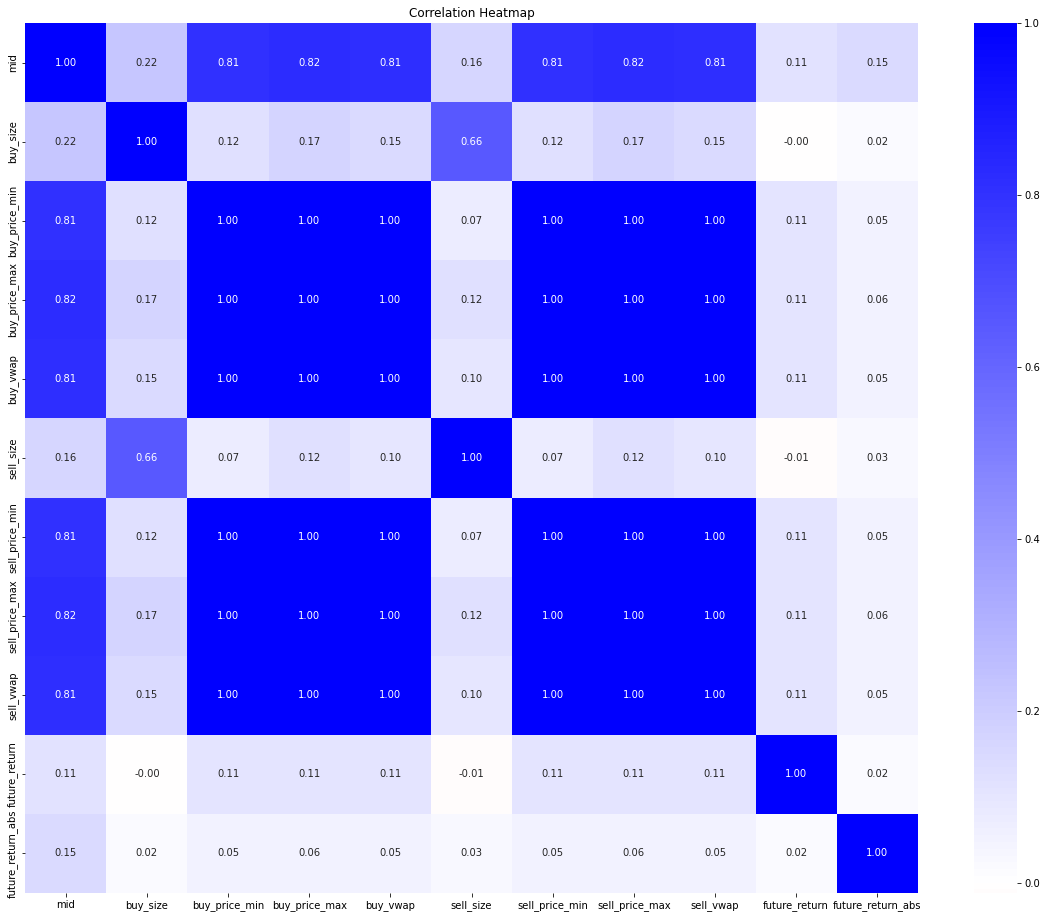

          Feature  Mutual Information
0             mid            0.098545
1        buy_size            0.000000
2   buy_price_min            0.061803
3   buy_price_max            0.070249
4        buy_vwap            0.057937
5       sell_size            0.000000
6  sell_price_min            0.061267
7  sell_price_max            0.066105
8       sell_vwap            0.051687


In [28]:
df['future_return'] = np.log(df['mid'] / df['mid'].shift(-5)) * 10000.0
df['future_return_abs'] = np.abs(df['future_return'])

show_heat_map(df)
xcols = ['mid', 'buy_size', 'buy_price_min', 'buy_price_max', 'buy_vwap',
       'sell_size', 'sell_price_min', 'sell_price_max', 'sell_vwap']
print_mutual_info(df, xcols, 'future_return_abs')

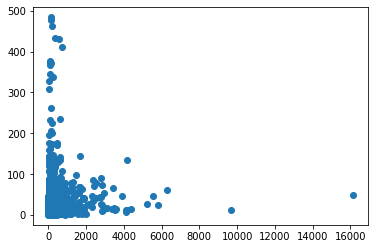

In [30]:
plt.scatter(x=df['buy_size'], y=df['future_return_abs'])

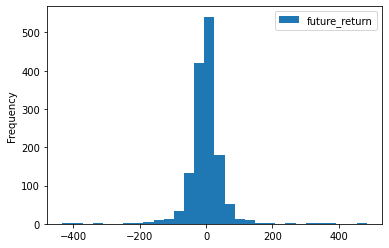

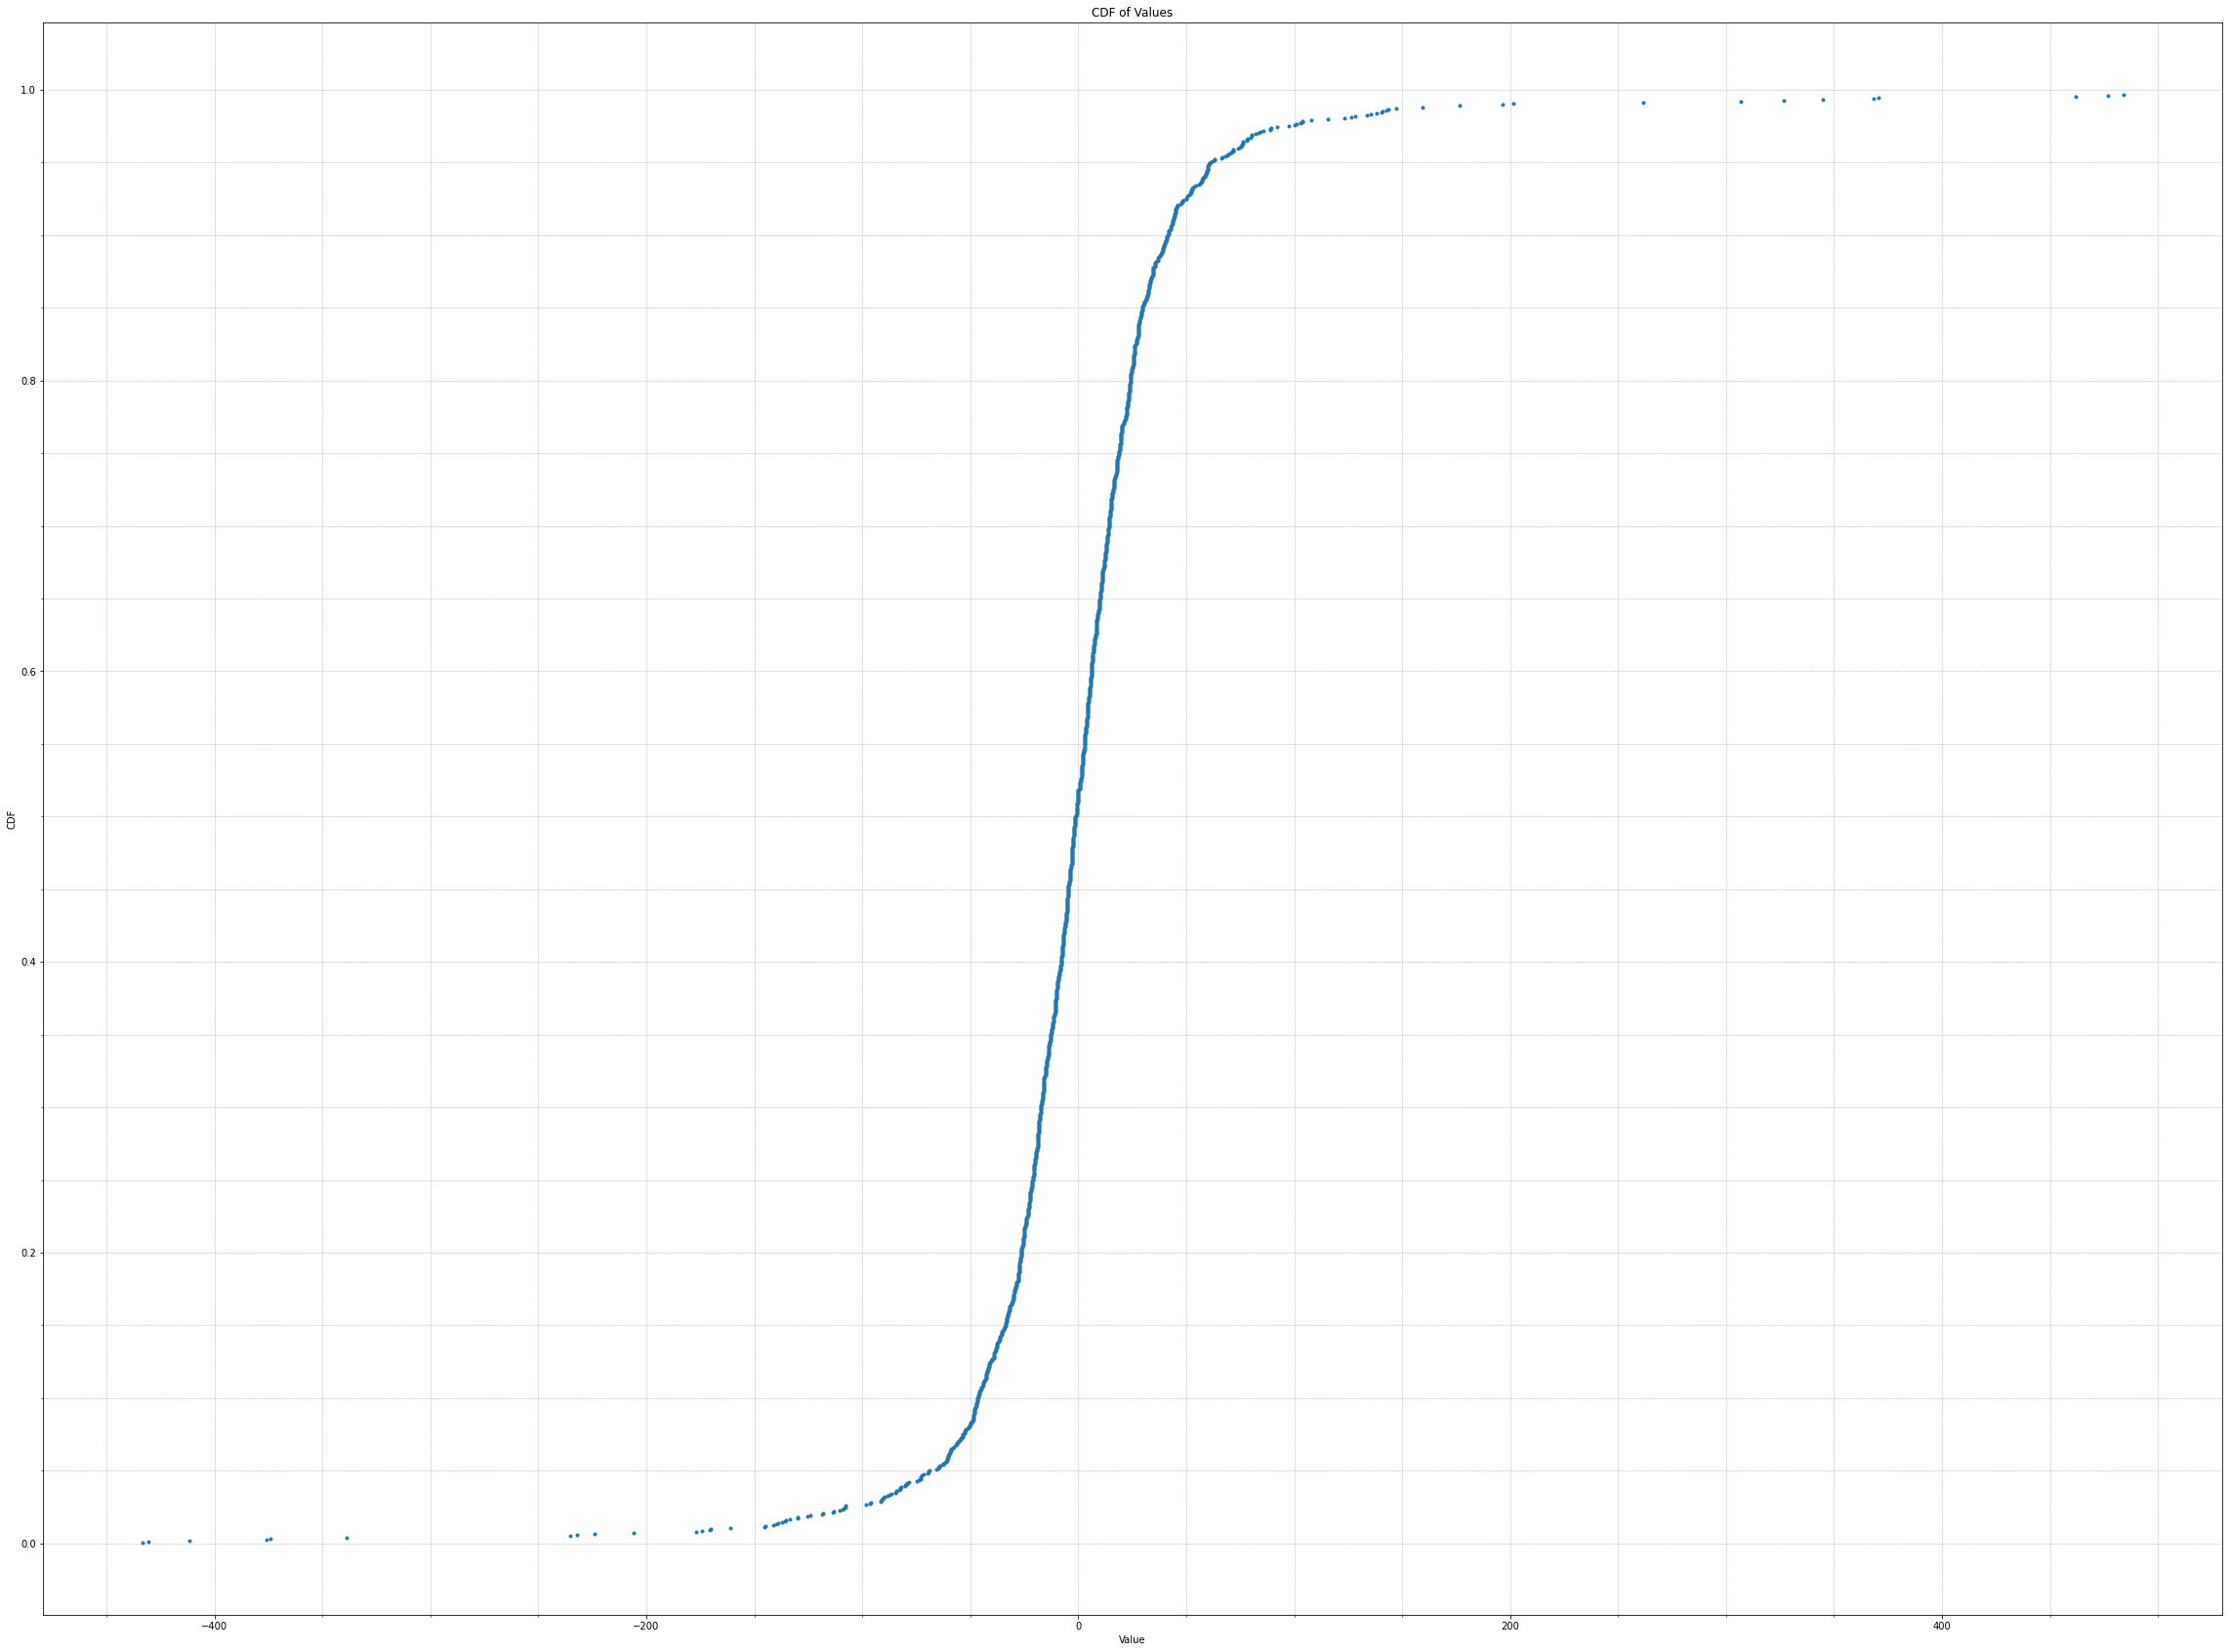

In [23]:
df['future_return'] = np.log(df['mid'] / df['mid'].shift(-5)) * 10000.0
df[['future_return']].plot(kind='hist', bins=30)

# Calculate the CDF (Cumulative Distribution Function)
sorted_data = np.sort(df['future_return'])
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the CDF
plt.figure(figsize=(40, 30))
plt.plot(sorted_data, cdf, marker='.', linestyle='none')
plt.title('CDF of Values')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.show()

<Axes: ylabel='Frequency'>

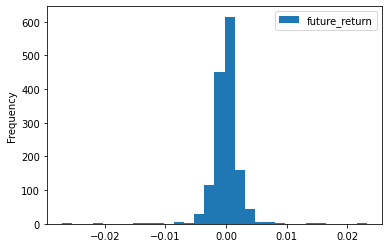